# 機械学習ハンズオン　練習問題3：銀行のキャンペーン申込予測

[UCIのbank marketingデータセット](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)を使って、顧客属性、過去のコンタクト履歴および市況情報を基に、顧客が定期預金に申し込んでくれるかどうかを予測します。


【課題】

 1. 混同行列(Confusion Matrix)を算出してください。
 1. 適合率(Precision)、再現率(Recall)、F1値(F1-score)を算出してください。
 
【ヒント】

 * 混同行列
 
| | 予測：正 | 予測：負 |
| --- | :---: | :---: |
| 正解：正 | True Positive (TP) | False Negative (FN) |
| 正解：負 | False Positive (FP) | True Negative (TN) | 

 * 適合率、再現率、F値の計算
   * $ Precision = \frac{TP}{TP+FP} $
   * $ Recall = \frac{TP}{TP+FN} $
   * $ F_1 = \frac{2PR}{P+R} $ ※P:Precision, R:Recall

 * [sklearn.metricsパッケージ](https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics)を参照
 

【注意点】

ラベルの偏りに注意してください。預金の申込をしなかった人が9割近くを占めています。

## 前準備

In [0]:
# ここで必要なimportを行ってください。
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### データセットファイルの取得（zipの展開）

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
!unzip -o bank.zip

--2019-07-22 15:01:05--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579043 (565K) [application/x-httpd-php]
Saving to: ‘bank.zip’

bank.zip            100%[===================>] 565.47K  1.77MB/s    in 0.3s    

2019-07-22 15:01:06 (1.77 MB/s) - ‘bank.zip’ saved [579043/579043]

Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


### データセットの読込み

データセットの説明に従って、 `duration` は外します。

> Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.


In [0]:
df = pd.read_csv('bank.csv', sep=';')
df = df.drop(['duration'], axis=1)

In [4]:
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,1,-1,0,unknown,no
5,35,management,single,tertiary,no,747,no,no,cellular,23,feb,2,176,3,failure,no
6,36,self-employed,married,tertiary,no,307,yes,no,cellular,14,may,1,330,2,other,no
7,39,technician,married,secondary,no,147,yes,no,cellular,6,may,2,-1,0,unknown,no
8,41,entrepreneur,married,tertiary,no,221,yes,no,unknown,14,may,2,-1,0,unknown,no
9,43,services,married,primary,no,-88,yes,yes,cellular,17,apr,1,147,2,failure,no


## データの分析

### クラスごとのデータ数

In [5]:
df.groupby('y').size() / len(df)

y
no     0.88476
yes    0.11524
dtype: float64

### 各特徴の分布と相関関係

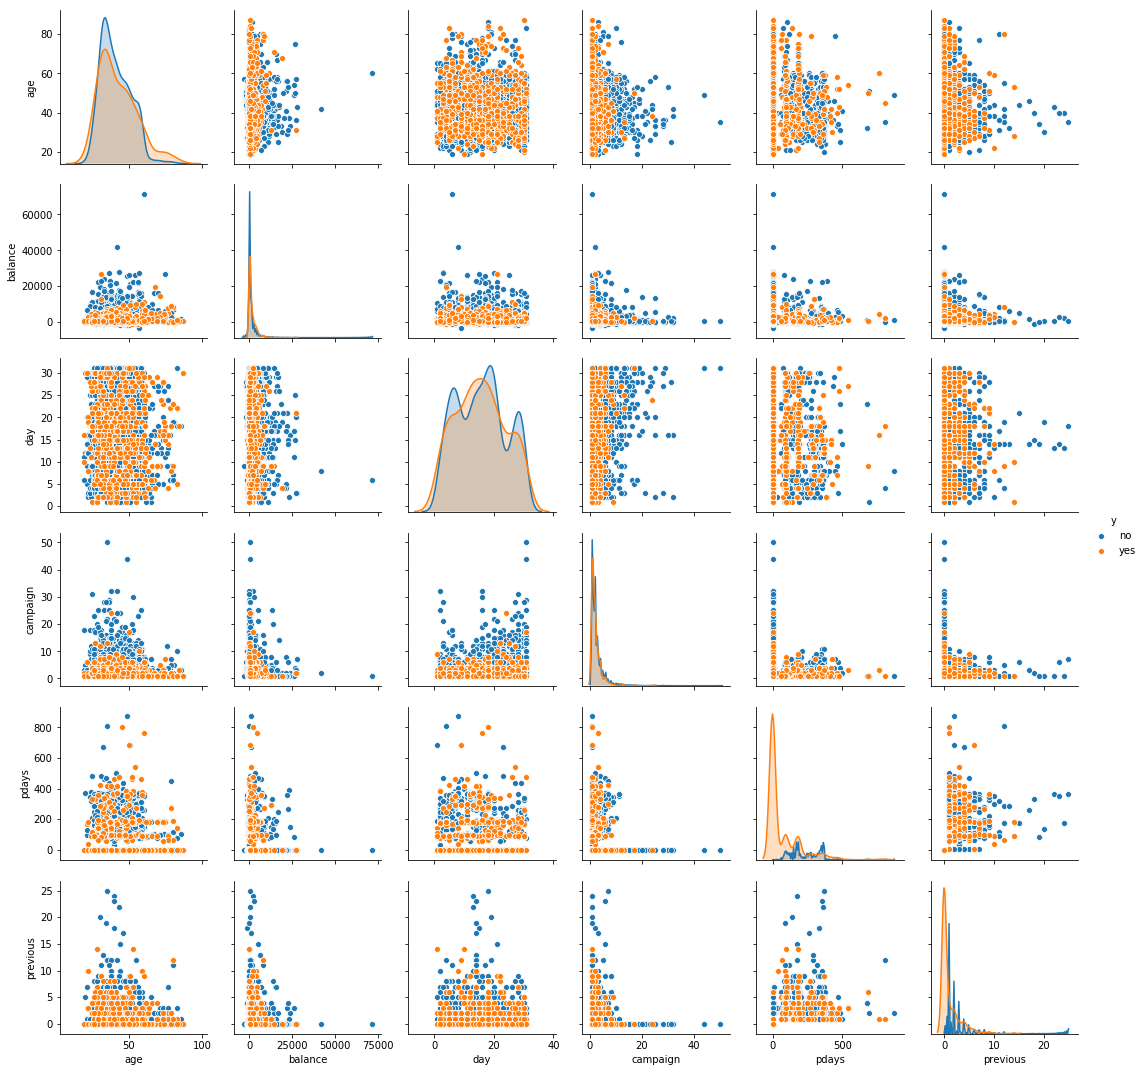

In [6]:
sns.pairplot(df, hue='y')

In [7]:
df[df['y']=='no'].describe()

,age,balance,day,campaign,pdays,previous
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,40.998000,1403.211750,15.948750,2.862250,36.006000,0.471250
std,10.188398,3075.349313,8.249736,3.212609,96.297657,1.627371
min,19.000000,-3313.000000,1.000000,1.000000,-1.000000,0.000000
25%,33.000000,61.000000,8.000000,1.000000,-1.000000,0.000000
50%,39.000000,419.500000,16.000000,2.000000,-1.000000,0.000000
75%,48.000000,1407.000000,21.000000,3.000000,-1.000000,0.000000
max,86.000000,71188.000000,31.000000,50.000000,871.000000,25.000000


In [8]:
df[df['y']=='yes'].describe()

,age,balance,day,campaign,pdays,previous
count,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000
mean,42.491363,1571.955854,15.658349,2.266795,68.639155,1.090211
std,13.115772,2444.398956,8.235148,2.092071,121.963063,2.055368
min,19.000000,-1206.000000,1.000000,1.000000,-1.000000,0.000000
25%,32.000000,171.000000,9.000000,1.000000,-1.000000,0.000000
50%,40.000000,710.000000,15.000000,2.000000,-1.000000,0.000000
75%,50.000000,2160.000000,22.000000,3.000000,98.000000,2.000000
max,87.000000,26965.000000,31.000000,24.000000,804.000000,14.000000


### 各カテゴリーデータのクラス別のクロス集計

In [9]:
pd.crosstab(index=df['y'], columns=df['job'], normalize='columns')

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
y,,,,,,,,,,,,
no,0.878661,0.927061,0.910714,0.875,0.864809,0.765217,0.89071,0.908873,0.77381,0.891927,0.898438,0.815789
yes,0.121339,0.072939,0.089286,0.125,0.135191,0.234783,0.10929,0.091127,0.22619,0.108073,0.101562,0.184211


In [10]:
pd.crosstab(index=df['y'], columns=df['marital'], normalize='columns')

marital,divorced,married,single
y,,,
no,0.854167,0.900965,0.860368
yes,0.145833,0.099035,0.139632


In [11]:
pd.crosstab(index=df['y'], columns=df['education'], normalize='columns')

education,primary,secondary,tertiary,unknown
y,,,,
no,0.905605,0.893755,0.857037,0.898396
yes,0.094395,0.106245,0.142963,0.101604


In [12]:
pd.crosstab(index=df['y'], columns=df['default'], normalize='columns')

default,no,yes
y,,
no,0.884814,0.881579
yes,0.115186,0.118421


In [13]:
pd.crosstab(index=df['y'], columns=df['housing'], normalize='columns')

housing,no,yes
y,,
no,0.846585,0.914029
yes,0.153415,0.085971


In [14]:
pd.crosstab(index=df['y'], columns=df['loan'], normalize='columns')

loan,no,yes
y,,
no,0.875196,0.937771
yes,0.124804,0.062229


In [15]:
pd.crosstab(index=df['y'], columns=df['contact'], normalize='columns')

contact,cellular,telephone,unknown
y,,,
no,0.856354,0.853821,0.953927
yes,0.143646,0.146179,0.046073


In [16]:
pd.crosstab(index=df['y'], columns=df['month'], normalize='columns')

month,apr,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sep
y,,,,,,,,,,,,
no,0.808874,0.875197,0.55,0.828829,0.891892,0.913598,0.896422,0.571429,0.933476,0.899743,0.5375,0.673077
yes,0.191126,0.124803,0.45,0.171171,0.108108,0.086402,0.103578,0.428571,0.066524,0.100257,0.4625,0.326923


In [17]:
pd.crosstab(index=df['y'], columns=df['poutcome'], normalize='columns')

poutcome,failure,other,success,unknown
y,,,,
no,0.871429,0.807107,0.356589,0.909042
yes,0.128571,0.192893,0.643411,0.090958


## 学習データの作成

### ラベル

In [18]:
ys = pd.get_dummies(df['y'], drop_first=True).values
ys

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=uint8)

### 特徴量

In [19]:
drop_columns = ['age', 'day', 'pdays', 'education']
df = df.drop(drop_columns, axis=1)
df = pd.get_dummies(df, drop_first=True)
df

,balance,campaign,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,y_yes
0,1787,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,4789,1,4,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,1350,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1476,4,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
5,747,2,3,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6,307,1,2,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
7,147,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
8,221,2,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
9,-88,1,2,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
xs = df.values
xs

array([[1787,    1,    0, ...,    0,    1,    0],
       [4789,    1,    4, ...,    0,    0,    0],
       [1350,    1,    1, ...,    0,    0,    0],
       ...,
       [ 295,   11,    0, ...,    0,    1,    0],
       [1137,    4,    3, ...,    0,    0,    0],
       [1136,    2,    7, ...,    0,    0,    0]])

### 特徴量の正規化

In [0]:
xs = StandardScaler().fit_transform(xs)


### 訓練データとテストデータの分割

In [22]:
train_xs, test_xs, train_ys, test_ys = train_test_split(xs, ys, test_size=0.2)
print(train_xs.shape, train_ys.shape, test_xs.shape, test_ys.shape)

(3616, 36) (3616, 1) (905, 36) (905, 1)


## モデルの構築

In [23]:
regularizer = None
model = tf.keras.models.Sequential([
    #tf.keras.layers.Dense(8, input_dim=train_xs.shape[1], activation='relu', kernel_regularizer=regularizer),
    #tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=regularizer),
    #tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizer)
    tf.keras.layers.Dense(1, input_dim=train_xs.shape[1], activation='sigmoid', kernel_regularizer=regularizer),
])

W0722 15:01:23.531265 140138573023104 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## モデルのコンパイル

In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

W0722 15:01:23.646090 140138573023104 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 37        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


## 学習実行

In [25]:
num_epochs = 100
hist = model.fit(train_xs, train_ys, epochs=num_epochs, validation_data=(test_xs, test_ys))

Train on 3616 samples, validate on 905 samples
Epoch 1/100
3616/3616 [==============================] - 1s 323us/sample - loss: 0.7566 - acc: 0.5705 - val_loss: 0.7165 - val_acc: 0.6265
Epoch 2/100
3616/3616 [==============================] - 1s 184us/sample - loss: 0.6479 - acc: 0.6781 - val_loss: 0.6239 - val_acc: 0.7215
Epoch 3/100
3616/3616 [==============================] - 1s 143us/sample - loss: 0.5612 - acc: 0.7760 - val_loss: 0.5486 - val_acc: 0.7923
Epoch 4/100
3616/3616 [==============================] - 1s 161us/sample - loss: 0.4911 - acc: 0.8595 - val_loss: 0.4858 - val_acc: 0.8575
Epoch 5/100
3616/3616 [==============================] - 1s 169us/sample - loss: 0.4340 - acc: 0.9134 - val_loss: 0.4335 - val_acc: 0.9127
Epoch 6/100
3616/3616 [==============================] - 1s 175us/sample - loss: 0.3864 - acc: 0.9513 - val_loss: 0.3890 - val_acc: 0.9448
Epoch 7/100
3616/3616 [==============================] - 1s 189us/sample - loss: 0.3463 - acc: 0.9743 - val_loss: 0.350

## 評価

### 損失・正答率

Text(0, 0.5, 'accuracy')

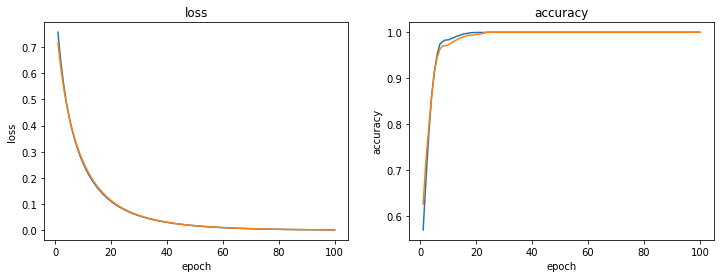

In [26]:
%matplotlib inline
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), hist.history["loss"])
plt.plot(range(1, num_epochs+1), hist.history["val_loss"])
plt.title("loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), hist.history["acc"])
plt.plot(range(1, num_epochs+1), hist.history["val_acc"])
plt.title("accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")

### 適合率・再現率・F値

In [27]:
pred = model.predict_classes(test_xs, batch_size=128)
accuracy = accuracy_score(test_ys, pred)
precision = precision_score(test_ys, pred)
recall = recall_score(test_ys, pred)
f1 = f1_score(test_ys, pred)
print("accuracy = {:.2f}, precision = {:.2f}, recall = {:.2f}, F1-score = {:.2f}".format(accuracy, precision, recall, f1))

accuracy = 1.00, precision = 1.00, recall = 1.00, F1-score = 1.00


### 混同行列

In [28]:
confusion_matrix(test_ys, pred)

array([[806,   0],
       [  0,  99]])